#Georgian Attractions Enrichment Pipeline

**Educational notebook** demonstrating the NLP enrichment pipeline.

##Pipeline Steps:

1.  **Data Loading** - From HuggingFace or local files

2.  **NER Extraction** - Named entities (locations, organizations)

3.  **Category Classification** - 5 categories (nature, history, culture, spirituality, architecture)

4.  **Tag Generation** - Relevant tags for search

5.  **Location extraction** - Extract location from ner

6.  **Quality Checks** - Validation and statistics


## Setup & Installation

In [1]:
!pip install -q transformers torch datasets pandas
!pip install -q python-Levenshtein fuzzywuzzy
!pip install -q protobuf sentencepiece tiktoken
!pip install spacy
!pip install fuzzywuzzy
!pip install -q textstat

In [2]:
import pandas as pd
import torch
from transformers import pipeline
from datasets import load_dataset
from fuzzywuzzy import fuzz
import json
import spacy
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

##Step 1: Data Loading


Since the dataset has already been created and published, I will only take two columns from the dataset with the name and description of the objects to demonstrate enrichment and dataset creation.

In [41]:
"""
Creates two independent dataframes:
- df_en: English landmarks
- df_ru: Russian landmarks

Each will be enriched separately in the notebook process..
"""

print(" Loading dataset from HuggingFace...")


# Load dataset
dataset = load_dataset("AIAnastasia/Georgian-attractions")
df_full = dataset['train'].to_pandas()

print(f" Loaded {len(df_full)} total records")

# ENGLISH DATAFRAME

print("\n Creating English dataframe...")

df_en = df_full[df_full['language'] == 'en'][['name', 'description']].copy()
df_en.columns = ['name_en', 'description_en']
df_en = df_en.reset_index(drop=True)

print(f" df_en ready: {len(df_en)} attractions")
print(f"   Columns: {list(df_en.columns)}")

# RUSSIAN DATAFRAME

print("\n Creating Russian dataframe...")

df_ru = df_full[df_full['language'] == 'ru'][['name', 'description']].copy()
df_ru.columns = ['name_ru', 'description_ru']
df_ru = df_ru.reset_index(drop=True)

print(f" df_ru ready: {len(df_ru)} attractions")
print(f"   Columns: {list(df_ru.columns)}")

# SUMMARY
print(f"English attractions: {len(df_en)}")
print(f"Russian attractions: {len(df_ru)}")
print(f"\nTotal: {len(df_en) + len(df_ru)} records")

# SHOW SAMPLES

print("\n Sample English attraction:")
if len(df_en) > 0:
    sample_en = df_en.iloc[0]
    print(f"   Name: {sample_en['name_en']}")
    print(f"   Description: {sample_en['description_en'][:100]}...")

print("\n Sample Russian attraction:")
if len(df_ru) > 0:
    sample_ru = df_ru.iloc[0]
    print(f"   Название: {sample_ru['name_ru']}")
    print(f"   Описание: {sample_ru['description_ru'][:100]}...")
print("""
 Next steps:
   1. NER Extraction    → Add ner_en / ner_ru columns
   2. Classification    → Add category_en / category_ru columns
   3. Tag Generation    → Add tags_en / tags_ru columns
   4. Location Extract  → Add location_en / location_ru columns

Let's enrich these datasets!
""")

# Display first rows of each
print("\n df_en (first 3 rows):")
display(df_en.head(3))

print("\n df_ru (first 3 rows):")
display(df_ru.head(3))

 Loading dataset from HuggingFace...
 Loaded 1628 total records

 Creating English dataframe...
 df_en ready: 727 attractions
   Columns: ['name_en', 'description_en']

 Creating Russian dataframe...
 df_ru ready: 901 attractions
   Columns: ['name_ru', 'description_ru']
English attractions: 727
Russian attractions: 901

Total: 1628 records

 Sample English attraction:
   Name: Lake Tabatskuri
   Description: Lake Tabatskuriis located inSamtskhe - Javakhetiregion, on the border ofBorjomiand Akhalkalaki munic...

 Sample Russian attraction:
   Название: Церковь Святого Георгия в Даба
   Описание: Церковь Святого Георгия в Даба находится в муниципалитете Боржоми в деревне Даба. Он является одной ...

 Next steps:
   1. NER Extraction    → Add ner_en / ner_ru columns
   2. Classification    → Add category_en / category_ru columns
   3. Tag Generation    → Add tags_en / tags_ru columns
   4. Location Extract  → Add location_en / location_ru columns

Let's enrich these datasets!


 df_en (f

,name_en,description_en
0,Lake Tabatskuri,Lake Tabatskuriis located inSamtskhe - Javakhe...
1,Martoti Lake,LakeMartotiis located inKakhetiregion specific...
2,Sabaduri Forest,Sabaduri Forestis located in theMtskheta-Mtian...



 df_ru (first 3 rows):


,name_ru,description_ru
0,Церковь Святого Георгия в Даба,Церковь Святого Георгия в Даба находится в мун...
1,Крепость Коджори (замок Короглы),Крепость Коджори(замок Короглы)- находится вТб...
2,Зеленый монастырь,Зеленый монастырь(Читахевский Георгиевский мон...


##Step 2: NER (Named Entity Recognition)

Extract named entities from descriptions: locations, organizations, persons.

**Models Used:**
 - **English:** dslim/bert-base-NER
 - **Russian:** Davlan/xlm-roberta-base-ner-hrl

###An example of extraction of ner for two languages:

In [4]:
from transformers import pipeline

ner_pipeline_en = pipeline("ner", model="dslim/bert-base-NER", aggregation_strategy="simple")
text_en = "Lake Tabatskuriis located inSamtskhe - Javakhetiregion, on the border ofBorjomiand Akhalkalaki municipalities, at an altitude of 1991 meters. Its mirror area is 14.2 km², maximum depth is 40.2 meters, average depth is 15.5 meters. The lake's structural basin is caused by the puddling of lava flows and is replenished by underground, snow and rain waters.  In winter it is frozen. The lake is surrounded by the Ktsia-Tabatskuri Reserve. The water is fresh and rich in fish, crabs can be also found there. There are two villages around the lake, Tabatskuri and Moliti. The village ofTabatskuriis built on the peninsula, which is partly invaded in the lake. It makes this place even more interesting and attractive. The blue lake, expansive spaces and mountains make a  spectacular sight.Tabatskuri is located 60 kilometers away fromBorjomi. It is possible to get there from Akhalkalaki andBakuriani. As you pass Bakuriani, the dirt road begins, where you can move by a Sedan. However, caution is important. In winter and early spring it is impossible to drive by car from Bakuriani side to Tabatskuri, as the road is closed. On the side of Akhalkalaki, the last section of the road is a dirt road and you can move here by a sedan. In winter, to get to Tabatskuri it is possible only from the Akhalkalakiside."
entities_en = ner_pipeline_en(text_en)
print(entities_en)

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


[{'entity_group': 'LOC', 'score': np.float32(0.7959448), 'word': 'Lake', 'start': 0, 'end': 4}, {'entity_group': 'LOC', 'score': np.float32(0.91795236), 'word': 'Tabatskuri', 'start': 5, 'end': 15}, {'entity_group': 'LOC', 'score': np.float32(0.9157123), 'word': '##Samtskhe', 'start': 28, 'end': 36}, {'entity_group': 'LOC', 'score': np.float32(0.98176), 'word': 'Javakhetire', 'start': 39, 'end': 50}, {'entity_group': 'LOC', 'score': np.float32(0.701044), 'word': '##Borjomian', 'start': 72, 'end': 81}, {'entity_group': 'LOC', 'score': np.float32(0.8451108), 'word': 'Akhalkalaki', 'start': 83, 'end': 94}, {'entity_group': 'LOC', 'score': np.float32(0.90104), 'word': 'Ktsia', 'start': 411, 'end': 416}, {'entity_group': 'LOC', 'score': np.float32(0.8829743), 'word': 'Tabatskuri Reserve', 'start': 417, 'end': 435}, {'entity_group': 'LOC', 'score': np.float32(0.9568213), 'word': 'Tabatskuri', 'start': 545, 'end': 555}, {'entity_group': 'LOC', 'score': np.float32(0.86806226), 'word': 'Moliti'

In [5]:
from transformers import pipeline

ner_pipeline_ru = pipeline("ner", model="Davlan/xlm-roberta-base-ner-hrl", aggregation_strategy="simple")
text_ru = "Озеро Табацкури расположено в регионе Самцхе-Джавахети, на границе муниципалитетов Боржоми и Ахалкалаки, на высоте 1991 метр. Площадь зеркала озера составляет 14,2 км², максимальная глубина — 40,2 метра, средняя глубина — 15,5 метра. Структурная котловина озера образована за счет застоя лавовых потоков и пополняется подземными, снеговыми и дождевыми водами. Зимой оно замерзает. Озеро окружено заповедником Кциа-Табацкури. Вода пресная и богата рыбой, крабы водятся всего в…0 километрах от Боржоми. Добраться туда можно из Ахалкалаки и Бакуриани."
entities_ru = ner_pipeline_ru(text_ru)
entities_ru

Device set to use cpu


[{'entity_group': 'LOC',
  'score': np.float32(0.9978728),
  'word': 'О',
  'start': 0,
  'end': 1},
 {'entity_group': 'LOC',
  'score': np.float32(0.96359473),
  'word': 'зеро Табацкури',
  'start': 1,
  'end': 15},
 {'entity_group': 'LOC',
  'score': np.float32(0.9995409),
  'word': 'Самцхе-Джавахети',
  'start': 37,
  'end': 54},
 {'entity_group': 'LOC',
  'score': np.float32(0.9994419),
  'word': 'Боржоми',
  'start': 82,
  'end': 90},
 {'entity_group': 'LOC',
  'score': np.float32(0.999492),
  'word': 'Ахалкалаки',
  'start': 92,
  'end': 103},
 {'entity_group': 'LOC',
  'score': np.float32(0.59065837),
  'word': 'заповед',
  'start': 395,
  'end': 403},
 {'entity_group': 'LOC',
  'score': np.float32(0.9879741),
  'word': 'Кциа-Табацкури',
  'start': 408,
  'end': 423},
 {'entity_group': 'LOC',
  'score': np.float32(0.9994537),
  'word': 'Боржоми',
  'start': 491,
  'end': 499},
 {'entity_group': 'LOC',
  'score': np.float32(0.99945533),
  'word': 'Ахалкалаки',
  'start': 524,
  '

###Loading models

In [6]:
ner_en = pipeline(
    "ner",
    model="dslim/bert-base-NER",
    aggregation_strategy="simple",
    device=-1
)
ner_ru = pipeline(
    "ner",
    model="Davlan/xlm-roberta-base-ner-hrl",
    aggregation_strategy="simple",
    device=-1
)

print("NER models loaded!")

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu
Device set to use cpu


NER models loaded!


###A generic function with error handling

In [7]:
def extract_entities(text, ner_pipeline):
    """
    Extract and organize entities from text.

    Args:
        text: Input text
        ner_pipeline: NER pipeline to use

    Returns:
        dict: Organized entities by type
    """
    if not text or pd.isna(text):
        return {}

    try:
        # Extract entities
        entities = ner_pipeline(text)

        # Organize by type
        organized = {}

        for entity in entities:
            entity_type = entity['entity_group']
            entity_text = entity['word']

            if entity_type not in organized:
                organized[entity_type] = []

            # Avoid duplicates
            if entity_text not in organized[entity_type]:
                organized[entity_type].append(entity_text)

        return organized

    except Exception as e:
        print(f"  Error processing text: {str(e)[:50]}...")
        return {}

### EXAMPLE: Single Attraction

In [8]:
print("EXAMPLE: NER on Single Attraction")

# English example
example_text_en = df_en.iloc[0]['description_en']
example_ner_en = extract_entities(example_text_en, ner_en)

print(f"\n English text:")
print(f"   {example_text_en[:150]}...")

print(f"\n  Extracted entities:")
for entity_type, entities in example_ner_en.items():
    print(f"   {entity_type:10s}: {', '.join(entities[:5])}")
    if len(entities) > 5:
        print(f"              ... and {len(entities) - 5} more")

# Russian example
example_text_ru = df_ru.iloc[0]['description_ru']
example_ner_ru = extract_entities(example_text_ru, ner_ru)

print(f"\n Russian text:")
print(f"   {example_text_ru[:150]}...")

print(f"\n  Extracted entities:")
for entity_type, entities in example_ner_ru.items():
    print(f"   {entity_type:10s}: {', '.join(entities[:5])}")
    if len(entities) > 5:
        print(f"              ... and {len(entities) - 5} more")

EXAMPLE: NER on Single Attraction

 English text:
   Lake Tabatskuriis located inSamtskhe - Javakhetiregion, on the border ofBorjomiand Akhalkalaki municipalities, at an altitude of 1991 meters. Its mirr...

  Extracted entities:
   LOC       : Lake, Tabatskuri, ##Samtskhe, Javakhetire, ##Borjomian
              ... and 12 more
   MISC      : Sedan

 Russian text:
   Церковь Святого Георгия в Даба находится в муниципалитете Боржоми в деревне Даба. Он является одной из древнейших и сильнейших храмов в Грузии, которо...

  Extracted entities:
   LOC       : Церковь Святого Георгия, Даба, Боржоми, Грузии, Церков
   PER       : Георгия V блистательного, Георгия


### Process ALL English and Russian attractions

In [9]:
print(" PROCESSING ENGLISH ATTRACTIONS")
# Enable progress bar
tqdm.pandas(desc="Extracting English NER")

# Process all descriptions
df_en['ner_en'] = df_en['description_en'].progress_apply(
    lambda x: extract_entities(x, ner_en)
)
print(f" Processed {len(df_en)} English attractions")
# Statistics
non_empty = df_en['ner_en'].apply(lambda x: len(x) > 0).sum()
print(f"   Attractions with entities: {non_empty}/{len(df_en)}")

# Show sample
print(f"\n Sample result:")
sample = df_en.iloc[0]
print(f"   Name: {sample['name_en']}")
print(f"   Entities: {sample['ner_en']}")
# Enable progress bar
tqdm.pandas(desc="Extracting Russian NER")


print(" PROCESSING RUSSIAN ATTRACTIONS")

# Enable progress bar
tqdm.pandas(desc="Extracting Russian NER")
# Process all descriptions
df_ru['ner_ru'] = df_ru['description_ru'].progress_apply(
    lambda x: extract_entities(x, ner_ru)
)

print(f" Processed {len(df_ru)} Russian attractions")
# Statistics
non_empty = df_ru['ner_ru'].apply(lambda x: len(x) > 0).sum()
print(f"   Attractions with entities: {non_empty}/{len(df_ru)}")

# Show sample
print(f"\n Sample result:")
sample = df_ru.iloc[0]
print(f"   Название: {sample['name_ru']}")
print(f"   Сущности: {sample['ner_ru']}")

 PROCESSING ENGLISH ATTRACTIONS


Extracting English NER: 100%|██████████| 727/727 [04:06<00:00,  2.95it/s]


 Processed 727 English attractions
   Attractions with entities: 721/727

 Sample result:
   Name: Lake Tabatskuri
   Entities: {'LOC': ['Lake', 'Tabatskuri', '##Samtskhe', 'Javakhetire', '##Borjomian', 'Akhalkalaki', 'Ktsia', 'Tabatskuri Reserve', 'Moliti', '##Tabatskuriis', '##Borjomi', 'A', '##khalkalaki', '##Bakuriani', 'Bakuriani', '##A', '##khalkalakiside'], 'MISC': ['Sedan']}
 PROCESSING RUSSIAN ATTRACTIONS


Extracting Russian NER: 100%|██████████| 901/901 [05:15<00:00,  2.86it/s]

 Processed 901 Russian attractions
   Attractions with entities: 898/901

 Sample result:
   Название: Церковь Святого Георгия в Даба
   Сущности: {'LOC': ['Церковь Святого Георгия', 'Даба', 'Боржоми', 'Грузии', 'Церков'], 'PER': ['Георгия V блистательного', 'Георгия']}


###Summary

In [10]:
print(" NER EXTRACTION SUMMARY")

# Count total entities
total_entities_en = sum(len(entities) for entities in df_en['ner_en'] if entities)
total_entities_ru = sum(len(entities) for entities in df_ru['ner_ru'] if entities)

print(f"English:")
print(f"   Total attractions: {len(df_en)}")
print(f"   With entities: {df_en['ner_en'].apply(lambda x: len(x) > 0).sum()}")
print(f"   Total entities extracted: {total_entities_en}")

print(f"\nRussian:")
print(f"   Total attractions: {len(df_ru)}")
print(f"   With entities: {df_ru['ner_ru'].apply(lambda x: len(x) > 0).sum()}")
print(f"   Total entities extracted: {total_entities_ru}")


 NER EXTRACTION SUMMARY
English:
   Total attractions: 727
   With entities: 721
   Total entities extracted: 1877

Russian:
   Total attractions: 901
   With entities: 898
   Total entities extracted: 1551


###Display results

In [11]:
print("\n Updated dataframes:")
print("\ndf_en (with NER):")

display(df_en[['name_en', 'ner_en']].head(3))
print("\ndf_ru (with NER):")

display(df_ru[['name_ru', 'ner_ru']].head(3))
print("\n NER extraction complete!")



 Updated dataframes:

df_en (with NER):


,name_en,ner_en
0,Lake Tabatskuri,"{'LOC': ['Lake', 'Tabatskuri', '##Samtskhe', '..."
1,Martoti Lake,"{'LOC': ['Lake', '##artot', '##Kakhetire', '##..."
2,Sabaduri Forest,"{'LOC': ['Sabaduri Forest', '##heta', 'Mtianet..."



df_ru (with NER):


,name_ru,ner_ru
0,Церковь Святого Георгия в Даба,"{'LOC': ['Церковь Святого Георгия', 'Даба', 'Б..."
1,Крепость Коджори (замок Короглы),"{'LOC': ['Крепость Коджори', 'замок', 'Короглы..."
2,Зеленый монастырь,"{'LOC': ['Зеленый монастырь', 'Читахевский Гео..."



 NER extraction complete!


##Step 3: Category Classification



Classify attractions into categories using zero-shot classification.

**Categories:**
- **Nature** - Parks, lakes, mountains
- **History** - Fortresses, historical sites
- **Culture** - Museums, theaters
- **Spirituality** - Churches, monasteries
- **Architecture** - Notable buildings

**Model:** joeddav/xlm-roberta-large-xnli

###Load classifier

In [12]:
classifier = pipeline(
    "zero-shot-classification",
    model="joeddav/xlm-roberta-large-xnli",
    device=-1
)

print(" Classifier loaded!")

Some weights of the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


 Classifier loaded!


###Define categories

In [13]:
# English categories
categories_en = [
    'nature',
    'history',
    'culture',
    'spirituality',
    'architecture'
]

# Russian categories
categories_ru = [
    'природа',
    'история',
    'культура',
    'духовность',
    'архитектура'
]
print(f"\n Categories:")
print(f"   English: {', '.join(categories_en)}")
print(f"   Russian: {', '.join(categories_ru)}")


 Categories:
   English: nature, history, culture, spirituality, architecture
   Russian: природа, история, культура, духовность, архитектура


###Simple classification function

In [14]:
def classify_text(text, categories):
    """
    Classify text into one of the predefined categories.

    Args:
        text: Description text
        categories: List of category labels

    Returns:
        str: Predicted category
    """
    if not text or pd.isna(text):
        return None

    try:
        result = classifier(text, candidate_labels=categories)
        return result['labels'][0]  # Top category
    except Exception as e:
        print(f"  Error: {str(e)[:50]}...")
        return None



### EXAMPLE: Single Attraction

In [15]:
print(" EXAMPLE: Classification on Single Attraction")

# English example
example_text_en = df_en.iloc[0]['description_en']
example_result_en = classifier(example_text_en, candidate_labels=categories_en)

print(f"\n English text:")
print(f"   {example_text_en[:150]}...")

print(f"\n Classification results:")
for label, score in zip(example_result_en['labels'][:3], example_result_en['scores'][:3]):
    bar = "█" * int(score * 20)
    print(f"   {label:15s}: {bar} {score:.1%}")

print(f"\n Predicted: {example_result_en['labels'][0]}")

# Russian example
example_text_ru = df_ru.iloc[0]['description_ru']
example_result_ru = classifier(example_text_ru, candidate_labels=categories_ru)

print(f"\n Russian text:")
print(f"   {example_text_ru[:150]}...")

print(f"\n Classification results:")
for label, score in zip(example_result_ru['labels'][:3], example_result_ru['scores'][:3]):
    bar = "█" * int(score * 20)
    print(f"   {label:15s}: {bar} {score:.1%}")

print(f"\n Predicted: {example_result_ru['labels'][0]}")

 EXAMPLE: Classification on Single Attraction

 English text:
   Lake Tabatskuriis located inSamtskhe - Javakhetiregion, on the border ofBorjomiand Akhalkalaki municipalities, at an altitude of 1991 meters. Its mirr...

 Classification results:
   culture        : ████ 20.5%
   architecture   : ████ 20.1%
   spirituality   : ███ 19.9%

 Predicted: culture

 Russian text:
   Церковь Святого Георгия в Даба находится в муниципалитете Боржоми в деревне Даба. Он является одной из древнейших и сильнейших храмов в Грузии, которо...

 Classification results:
   архитектура    : █████████ 45.1%
   культура       : ████ 20.3%
   история        : ██ 13.7%

 Predicted: архитектура


###Processing of all English and Russian landmarks

In [16]:
# Enable progress bar
tqdm.pandas(desc="Classifying English")

# Classify all descriptions
df_en['category_en'] = df_en['description_en'].progress_apply(
    lambda x: classify_text(x, categories_en)
)

print(f" Classified {len(df_en)} English attractions")
# Show distribution
print(f"\n Category distribution:")
category_counts_en = df_en['category_en'].value_counts()
for category, count in category_counts_en.items():
    percentage = (count / len(df_en)) * 100
    print(f"   {category:15s}: {count:3d} ({percentage:.1f}%)")

print(" CLASSIFYING RUSSIAN ATTRACTIONS")
# Enable progress bar
tqdm.pandas(desc="Classifying Russian")

# Classify all descriptions
df_ru['category_ru'] = df_ru['description_ru'].progress_apply(
    lambda x: classify_text(x, categories_ru)
)
print(f" Classified {len(df_ru)} Russian attractions")

# Show distribution
print(f"\n Category distribution:")
category_counts_ru = df_ru['category_ru'].value_counts()
for category, count in category_counts_ru.items():
    percentage = (count / len(df_ru)) * 100
    print(f"   {category:15s}: {count:3d} ({percentage:.1f}%)")

Classifying English: 100%|██████████| 727/727 [1:10:03<00:00,  5.78s/it]


 Classified 727 English attractions

 Category distribution:
   architecture   : 290 (39.9%)
   nature         : 193 (26.5%)
   culture        : 120 (16.5%)
   history        :  86 (11.8%)
   spirituality   :  38 (5.2%)
 CLASSIFYING RUSSIAN ATTRACTIONS


Classifying Russian: 100%|██████████| 901/901 [1:28:49<00:00,  5.92s/it]

 Classified 901 Russian attractions

 Category distribution:
   архитектура    : 435 (48.3%)
   природа        : 222 (24.6%)
   культура       :  98 (10.9%)
   история        :  90 (10.0%)
   духовность     :  56 (6.2%)


###Visualisation

VISUALIZATION


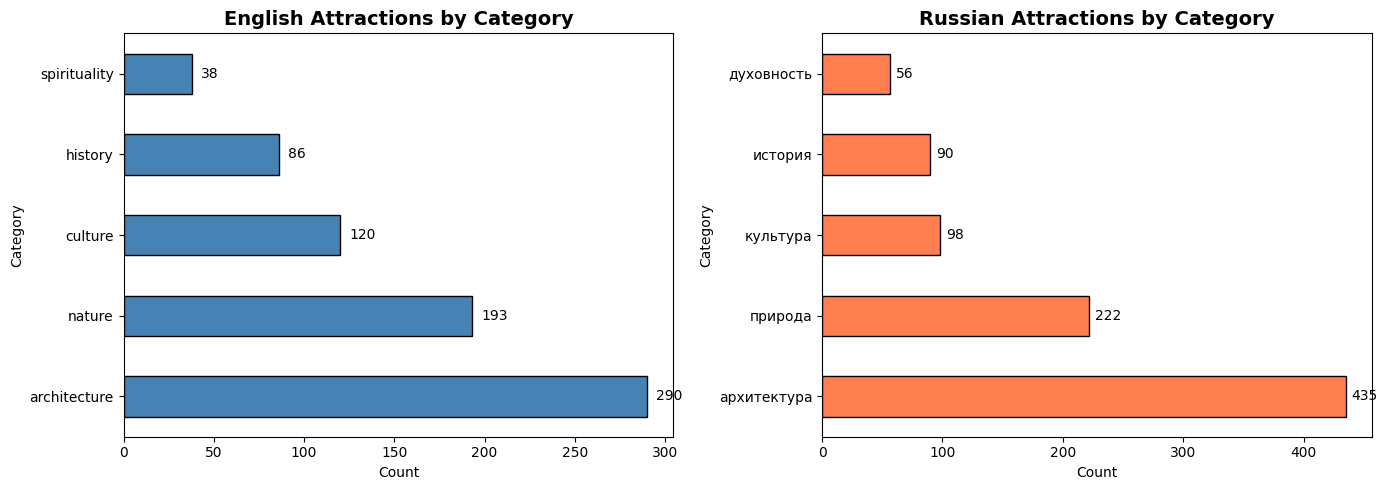

 Visualization complete!


In [17]:
print("VISUALIZATION")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# English distribution
category_counts_en.plot(
    kind='barh',
    ax=ax1,
    color='steelblue',
    edgecolor='black'
)
ax1.set_title('English Attractions by Category', fontsize=14, fontweight='bold')
ax1.set_xlabel('Count')
ax1.set_ylabel('Category')

# Add value labels
for i, v in enumerate(category_counts_en.values):
    ax1.text(v + 5, i, str(v), va='center')

# Russian distribution
category_counts_ru.plot(
    kind='barh',
    ax=ax2,
    color='coral',
    edgecolor='black'
)
ax2.set_title('Russian Attractions by Category', fontsize=14, fontweight='bold')
ax2.set_xlabel('Count')
ax2.set_ylabel('Category')

# Add value labels
for i, v in enumerate(category_counts_ru.values):
    ax2.text(v + 5, i, str(v), va='center')
plt.tight_layout()
plt.show()
print(" Visualization complete!")


### SUMMARY

In [18]:
print(" CLASSIFICATION SUMMARY")

print(f"English:")
print(f"   Total attractions: {len(df_en)}")
print(f"   Classified: {df_en['category_en'].notna().sum()}")
print(f"   Most common: {category_counts_en.index[0]} ({category_counts_en.values[0]} items)")

print(f"\nRussian:")
print(f"   Total attractions: {len(df_ru)}")
print(f"   Classified: {df_ru['category_ru'].notna().sum()}")
print(f"   Most common: {category_counts_ru.index[0]} ({category_counts_ru.values[0]}")

 CLASSIFICATION SUMMARY
English:
   Total attractions: 727
   Classified: 727
   Most common: architecture (290 items)

Russian:
   Total attractions: 901
   Classified: 901
   Most common: архитектура (435


###DISPLAY RESULTS

In [19]:
print("\n Updated dataframes:")

print("\ndf_en (with categories):")
display(df_en[['name_en', 'category_en']].head(5))

print("\ndf_ru (with categories):")
display(df_ru[['name_ru', 'category_ru']].head(5))
print("\n Category classification complete!")


 Updated dataframes:

df_en (with categories):


,name_en,category_en
0,Lake Tabatskuri,culture
1,Martoti Lake,nature
2,Sabaduri Forest,nature
3,Lakumurash Toba,nature
4,Small Toba (Okhoje Lake),nature



df_ru (with categories):


,name_ru,category_ru
0,Церковь Святого Георгия в Даба,архитектура
1,Крепость Коджори (замок Короглы),история
2,Зеленый монастырь,архитектура
3,Церковь Потолети,природа
4,Тимотесубани Монастырь,архитектура



 Category classification complete!


## Step 4:Tag Generation

Generate relevant tags for search and filtering.

**Tag Categories:**
- fortress, church, monastery, cathedral
- mountain, lake, waterfall, canyon
- museum, gallery, theater
- park, garden, reserve

**Model:**
- joeddav/xlm-roberta-large-xnli (same as classification)

###Define tags

In [20]:
# English tags
tags_en = [
    # Structures
    'fortress', 'church', 'monastery', 'cathedral', 'castle', 'bridge',
    # Nature
    'mountain', 'lake', 'waterfall', 'canyon', 'forest', 'river', 'cave',
    # Culture
    'museum', 'gallery', 'theater',
    # Spaces
    'park', 'garden', 'reserve', 'beach', 'national park'
]

# Russian tags
tags_ru = [
    # Structures
    'крепость', 'церковь', 'монастырь', 'собор', 'замок', 'мост',
    # Nature
    'гора', 'озеро', 'водопад', 'каньон', 'лес', 'река', 'пещера',
    # Culture
    'музей', 'галерея', 'театр',
    # Spaces
    'парк', 'сад', 'заповедник', 'пляж', 'национальный парк'
]

print("  Available tags:")
print(f"   English: {len(tags_en)} tags")
print(f"   Russian: {len(tags_ru)} tags")

  Available tags:
   English: 21 tags
   Russian: 21 tags


###Tag generation function

In [21]:
def generate_tags(text, candidate_tags, classifier, top_k=3, max_length=250):
    """
    Generate relevant tags for text using zero-shot classification.

    Args:
        text: Description text
        candidate_tags: List of possible tags
        classifier: Zero-shot classifier
        top_k: Number of tags to generate
        max_length: Maximum text length (default: 250 chars)

    Returns:
        list: Top-k relevant tags
    """
    if not text or pd.isna(text):
        return []

    try:
        # OPTIMIZATION: Truncate text to speed up classification
        if len(text) > max_length:
            text = text[:max_length]

        # Use zero-shot classification to score tags
        result = classifier(text, candidate_labels=candidate_tags)

        # Return top-k tags
        return result['labels'][:top_k]

    except Exception as e:
        print(f"  Error: {str(e)[:50]}...")
        return []

### EXAMPLE: Single Attraction

In [22]:
print("EXAMPLE: Tag Generation on Single Attraction")

# English example
example_text_en = df_en.iloc[0]['description_en']
example_tags_en = generate_tags(example_text_en, tags_en, classifier, top_k=3)

print(f"\n English text:")
print(f"   {example_text_en[:150]}...")

print(f"\n  Generated tags:")
for i, tag in enumerate(example_tags_en, 1):
    print(f"   {i}. {tag}")
# Russian example
example_text_ru = df_ru.iloc[0]['description_ru']
example_tags_ru = generate_tags(example_text_ru, tags_ru, classifier, top_k=3)

print(f"\n Russian text:")
print(f"   {example_text_ru[:150]}...")
print(f"\n  Generated tags:")
for i, tag in enumerate(example_tags_ru, 1):
    print(f"   {i}. {tag}")

EXAMPLE: Tag Generation on Single Attraction

 English text:
   Lake Tabatskuriis located inSamtskhe - Javakhetiregion, on the border ofBorjomiand Akhalkalaki municipalities, at an altitude of 1991 meters. Its mirr...

  Generated tags:
   1. lake
   2. mountain
   3. reserve

 Russian text:
   Церковь Святого Георгия в Даба находится в муниципалитете Боржоми в деревне Даба. Он является одной из древнейших и сильнейших храмов в Грузии, которо...

  Generated tags:
   1. собор
   2. церковь
   3. лес


###Process all English and Russian attractions

In [23]:
print(" GENERATING ENGLISH TAGS")

# Enable progress bar
tqdm.pandas(desc="Generating English tags")

# Generate tags for all descriptions
df_en['tags_en'] = df_en['description_en'].progress_apply(
    lambda x: generate_tags(x, tags_en, classifier, top_k=3)
)
print(f" Generated tags for {len(df_en)} English attractions")

# Statistics
with_tags = df_en['tags_en'].apply(lambda x: len(x) > 0).sum()
print(f"   Attractions with tags: {with_tags}/{len(df_en)}")

# Show sample
print(f"\n Sample results:")
for i in range(3):
    name = df_en.iloc[i]['name_en']
    tags = df_en.iloc[i]['tags_en']
    print(f"   {name}: {', '.join(tags)}")


print(" GENERATING RUSSIAN TAGS")
# Enable progress bar
tqdm.pandas(desc="Generating Russian tags")

# Generate tags for all descriptions
df_ru['tags_ru'] = df_ru['description_ru'].progress_apply(
    lambda x: generate_tags(x, tags_ru, classifier, top_k=3)
)
print(f" Generated tags for {len(df_ru)} Russian attractions")
with_tags = df_ru['tags_ru'].apply(lambda x: len(x) > 0).sum()

print(f"   Attractions with tags: {with_tags}/{len(df_ru)}")
# Show sample
print(f"\n Sample results:")
for i in range(3):
    name = df_ru.iloc[i]['name_ru']
    tags = df_ru.iloc[i]['tags_ru']
    print(f"   {name}: {', '.join(tags)}")

 GENERATING ENGLISH TAGS


Generating English tags: 100%|██████████| 727/727 [1:37:35<00:00,  8.05s/it]


 Generated tags for 727 English attractions
   Attractions with tags: 727/727

 Sample results:
   Lake Tabatskuri: lake, mountain, reserve
   Martoti Lake: monastery, lake, mountain
   Sabaduri Forest: forest, national park, park
 GENERATING RUSSIAN TAGS


Generating Russian tags: 100%|██████████| 901/901 [2:10:22<00:00,  8.68s/it]

 Generated tags for 901 Russian attractions
   Attractions with tags: 901/901

 Sample results:
   Церковь Святого Георгия в Даба: собор, церковь, лес
   Крепость Коджори (замок Короглы): замок, крепость, монастырь
   Зеленый монастырь: монастырь, лес, церковь


###Tag frequency analysis

In [24]:
print(" TAG FREQUENCY ANALYSIS")
# English tag frequency
all_tags_en = [tag for tags_list in df_en['tags_en'] if tags_list for tag in tags_list]
tag_freq_en = Counter(all_tags_en)

print(f"\n Top 10 English tags:")
for tag, count in tag_freq_en.most_common(10):
    percentage = (count / len(df_en)) * 100
    print(f"   {tag:20s}: {count:3d} ({percentage:.1f}%)")

# Russian tag frequency
all_tags_ru = [tag for tags_list in df_ru['tags_ru'] if tags_list for tag in tags_list]
tag_freq_ru = Counter(all_tags_ru)

print(f"\n Top 10 Russian tags:")
for tag, count in tag_freq_ru.most_common(10):
    percentage = (count / len(df_ru)) * 100
    print(f"   {tag:20s}: {count:3d} ({percentage:.1f}%)")

 TAG FREQUENCY ANALYSIS

 Top 10 English tags:
   reserve             : 421 (57.9%)
   church              : 214 (29.4%)
   monastery           : 181 (24.9%)
   mountain            : 174 (23.9%)
   castle              : 169 (23.2%)
   fortress            : 123 (16.9%)
   river               : 121 (16.6%)
   cathedral           : 112 (15.4%)
   park                : 110 (15.1%)
   lake                :  98 (13.5%)

 Top 10 Russian tags:
   монастырь           : 393 (43.6%)
   собор               : 358 (39.7%)
   церковь             : 322 (35.7%)
   заповедник          : 220 (24.4%)
   замок               : 208 (23.1%)
   крепость            : 190 (21.1%)
   гора                : 145 (16.1%)
   озеро               : 126 (14.0%)
   водопад             : 120 (13.3%)
   река                : 105 (11.7%)


###Visualisation

 VISUALIZATION


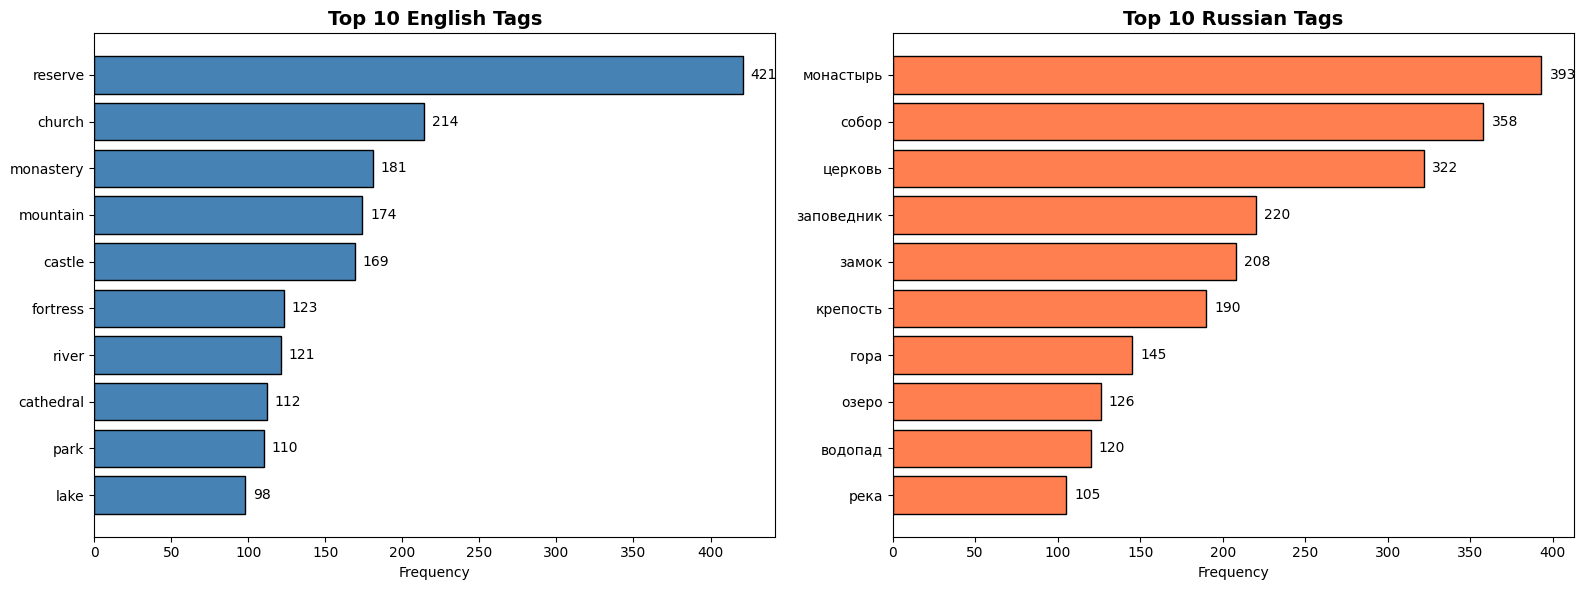

 Visualization complete!


In [25]:
print(" VISUALIZATION")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# English tags
top_tags_en = dict(tag_freq_en.most_common(10))
ax1.barh(list(top_tags_en.keys()), list(top_tags_en.values()), color='steelblue', edgecolor='black')
ax1.set_title('Top 10 English Tags', fontsize=14, fontweight='bold')
ax1.set_xlabel('Frequency')
ax1.invert_yaxis()
# Add value labels
for i, v in enumerate(top_tags_en.values()):
    ax1.text(v + 5, i, str(v), va='center')

# Russian tags
top_tags_ru = dict(tag_freq_ru.most_common(10))
ax2.barh(list(top_tags_ru.keys()), list(top_tags_ru.values()), color='coral', edgecolor='black')
ax2.set_title('Top 10 Russian Tags', fontsize=14, fontweight='bold')
ax2.set_xlabel('Frequency')
ax2.invert_yaxis()

# Add value labels
for i, v in enumerate(top_tags_ru.values()):
    ax2.text(v + 5, i, str(v), va='center')

plt.tight_layout()
plt.show()
print(" Visualization complete!")

### Summary

In [26]:
print(" TAG GENERATION SUMMARY")

print(f"English:")
print(f"   Total attractions: {len(df_en)}")
print(f"   With tags: {df_en['tags_en'].apply(lambda x: len(x) > 0).sum()}")
print(f"   Total tags generated: {len(all_tags_en)}")
print(f"   Unique tags used: {len(tag_freq_en)}")
print(f"   Most common: {tag_freq_en.most_common(1)[0][0]} ({tag_freq_en.most_common(1)[0][1]} times)")

print(f"\nRussian:")
print(f"   Total attractions: {len(df_ru)}")
print(f"   With tags: {df_ru['tags_ru'].apply(lambda x: len(x) > 0).sum()}")
print(f"   Total tags generated: {len(all_tags_ru)}")
print(f"   Unique tags used: {len(tag_freq_ru)}")
print(f"   Most common: {tag_freq_ru.most_common(1)[0][0]} ({tag_freq_ru.most_common(1)[0][0]}times)")

 TAG GENERATION SUMMARY
English:
   Total attractions: 727
   With tags: 727
   Total tags generated: 2181
   Unique tags used: 21
   Most common: reserve (421 times)

Russian:
   Total attractions: 901
   With tags: 901
   Total tags generated: 2703
   Unique tags used: 21
   Most common: монастырь (монастырьtimes)


###Display results

In [27]:
print("\n Updated dataframes:")
print("\ndf_en (with tags):")
display(df_en[['name_en', 'category_en', 'tags_en']].head(5))

print("\ndf_ru (with tags):")
display(df_ru[['name_ru', 'category_ru', 'tags_ru']].head(5))

print("\n Tag generation complete!")


 Updated dataframes:

df_en (with tags):


,name_en,category_en,tags_en
0,Lake Tabatskuri,culture,"[lake, mountain, reserve]"
1,Martoti Lake,nature,"[monastery, lake, mountain]"
2,Sabaduri Forest,nature,"[forest, national park, park]"
3,Lakumurash Toba,nature,"[mountain, lake, reserve]"
4,Small Toba (Okhoje Lake),nature,"[lake, reserve, park]"



df_ru (with tags):


,name_ru,category_ru,tags_ru
0,Церковь Святого Георгия в Даба,архитектура,"[собор, церковь, лес]"
1,Крепость Коджори (замок Короглы),история,"[замок, крепость, монастырь]"
2,Зеленый монастырь,архитектура,"[монастырь, лес, церковь]"
3,Церковь Потолети,природа,"[церковь, монастырь, собор]"
4,Тимотесубани Монастырь,архитектура,"[монастырь, церковь, собор]"



 Tag generation complete!


##STEP 5: Location extraction

Extract geographical locations from NER data.

**Process:**
-  Parse NER entities (already extracted in Step 2)
-  Find location entities (LOC, GPE)
-  Extract primary location for each attraction

This creates location_en and location_ru columns.

###Location extraction function

In [28]:
def extract_location_from_ner(ner_data):
    """
    Extract primary location from NER entities.
    Args:
        ner_data: Dictionary with NER entities

    Returns:
        str: Primary location or empty string
    """
    if not ner_data or pd.isna(ner_data):
        return ''

    # If it's a string, try to parse as JSON
    if isinstance(ner_data, str):
        try:
            ner_data = json.loads(ner_data)
        except:
            return ''

    # If it's not a dictionary, return empty
    if not isinstance(ner_data, dict):
        return ''

    # Try different location entity keys
    location_keys = [
        'LOC',           # Location (English model)
        'GPE',           # Geopolitical Entity
        'LABEL_0',       # Russian model format
        'LABEL_1',       # Russian model format
        'locations',
        'location',
        'LOCATION',
        'places'
    ]

    # Generic words to SKIP (not real locations)
    skip_words = {
        # English generic words
        'lake', 'river', 'mountain', 'church', 'monastery', 'fortress',
        'castle', 'museum', 'park', 'reserve', 'forest', 'canyon',
        'waterfall', 'cave', 'beach', 'bridge', 'tower', 'temple',
        'small', 'big', 'large', 'old', 'new', 'ancient', 'historic',
        'national', 'state', 'regional', 'local', 'main', 'central',
        # Russian generic words
        'озеро', 'река', 'гора', 'церковь', 'монастырь', 'крепость',
        'замок', 'музей', 'парк', 'заповедник', 'лес', 'каньон',
        'водопад', 'пещера', 'пляж', 'мост', 'башня', 'храм', 'собор',
        'зеленый', 'старый', 'новый', 'древний', 'святого', 'святой'
    }

    # Collect all potential locations
    all_locations = []

    # Try each key
    for key in location_keys:
        if key not in ner_data or not ner_data[key]:
            continue

        entities = ner_data[key]

        # If it's a list
        if isinstance(entities, list):
            for entity in entities:
                # If it's a string
                if isinstance(entity, str):
                    # Clean up tokenization artifacts
                    entity_clean = entity.replace('##', '').strip()

                    if (len(entity_clean) >= 4 and
                        entity_clean.lower() not in skip_words and
                        not entity.startswith('##') and
                        sum(c.isalpha() for c in entity_clean) >= len(entity_clean) * 0.7):
                        all_locations.append(entity_clean)

                # If it's a dict
                elif isinstance(entity, dict):
                    text = entity.get('text', entity.get('word', '')).replace('##', '').strip()
                    if (len(text) >= 4 and
                        text.lower() not in skip_words and
                        sum(c.isalpha() for c in text) >= len(text) * 0.7):
                        all_locations.append(text)

        # If it's a string directly
        elif isinstance(entities, str):
            entity_clean = entities.replace('##', '').strip()
            if (len(entity_clean) >= 4 and
                entity_clean.lower() not in skip_words and
                sum(c.isalpha() for c in entity_clean) >= len(entity_clean) * 0.7):
                all_locations.append(entity_clean)

    # Return first valid location
    if all_locations:
        # Prefer longer names (more specific)
        # Sort by length descending, take first
        all_locations.sort(key=len, reverse=True)
        return all_locations[0]

    return ''

### EXAMPLE: Single Attraction

In [29]:
print("  LOCATION EXTRACTION")
# English example
print("\n English example:")
example_ner_en = df_en.iloc[0]['ner_en']
example_location_en = extract_location_from_ner(example_ner_en)

print(f"   Attraction: {df_en.iloc[0]['name_en']}")
print(f"   NER entities: {example_ner_en}")
print(f"   → Extracted location: '{example_location_en}'")
# Russian example
print("\n Russian example:")
example_ner_ru = df_ru.iloc[0]['ner_ru']
example_location_ru = extract_location_from_ner(example_ner_ru)

print(f"   Достопримечательность: {df_ru.iloc[0]['name_ru']}")
print(f"   NER сущности: {example_ner_ru}")
print(f"   → Извлечённая локация: '{example_location_ru}'")


  LOCATION EXTRACTION

 English example:
   Attraction: Lake Tabatskuri
   NER entities: {'LOC': ['Lake', 'Tabatskuri', '##Samtskhe', 'Javakhetire', '##Borjomian', 'Akhalkalaki', 'Ktsia', 'Tabatskuri Reserve', 'Moliti', '##Tabatskuriis', '##Borjomi', 'A', '##khalkalaki', '##Bakuriani', 'Bakuriani', '##A', '##khalkalakiside'], 'MISC': ['Sedan']}
   → Extracted location: 'Tabatskuri Reserve'

 Russian example:
   Достопримечательность: Церковь Святого Георгия в Даба
   NER сущности: {'LOC': ['Церковь Святого Георгия', 'Даба', 'Боржоми', 'Грузии', 'Церков'], 'PER': ['Георгия V блистательного', 'Георгия']}
   → Извлечённая локация: 'Церковь Святого Георгия'


### Process all English and Russian attrstions

In [30]:
print(" EXTRACTING ENGLISH LOCATIONS")
# Extract locations from NER data
df_en['location_en'] = df_en['ner_en'].apply(extract_location_from_ner)
# Statistics
locations_found = df_en['location_en'].apply(lambda x: len(x) > 0).sum()
print(f" Processed {len(df_en)} English attractions")
print(f"   Locations found: {locations_found}/{len(df_en)} ({locations_found/len(df_en)*100:.1f}%)")

# Show samples
print(f"\n Sample results:")
for i in range(5):
    name = df_en.iloc[i]['name_en']
    location = df_en.iloc[i]['location_en']
    if location:
        print(f"   {name:30s} → {location}")
    else:
        print(f"   {name:30s} → (no location)")

print(" EXTRACTING RUSSIAN LOCATIONS")

# Extract locations from NER data
df_ru['location_ru'] = df_ru['ner_ru'].apply(extract_location_from_ner)

# Statistics
locations_found = df_ru['location_ru'].apply(lambda x: len(x) > 0).sum()
print(f" Processed {len(df_ru)} Russian attractions")
print(f"   Locations found: {locations_found}/{len(df_ru)} ({locations_found/len(df_ru)*100:.1f}%)")
# Show samples
print(f"\n Sample results:")
for i in range(5):
    name = df_ru.iloc[i]['name_ru']
    location = df_ru.iloc[i]['location_ru']
    if location:
        print(f"   {name:40s} → {location}")
    else:
        print(f"   {name:40s} → (no location)")


 EXTRACTING ENGLISH LOCATIONS
 Processed 727 English attractions
   Locations found: 712/727 (97.9%)

 Sample results:
   Lake Tabatskuri                → Tabatskuri Reserve
   Martoti Lake                   → Lagodekhi
   Sabaduri Forest                → Tbilisi National Park
   Lakumurash Toba                → Mestiamunicipality
   Small Toba (Okhoje Lake)       → ChkhorotskuM
 EXTRACTING RUSSIAN LOCATIONS
 Processed 901 Russian attractions
   Locations found: 897/901 (99.6%)

 Sample results:
   Церковь Святого Георгия в Даба           → Церковь Святого Георгия
   Крепость Коджори (замок Короглы)         → Триалетский Хребет
   Зеленый монастырь                        → Читахевский Георгиевский монастырь
   Церковь Потолети                         → Потолетского лес
   Тимотесубани Монастырь                   → Тимотесубани монастыр


###Location frequency analysis

In [31]:
print(" LOCATION FREQUENCY ANALYSIS")
# English locations
locations_en = df_en[df_en['location_en'] != '']['location_en']
location_freq_en = Counter(locations_en)

print(f"\n Top 15 English locations:")
for location, count in location_freq_en.most_common(15):
    percentage = (count / len(df_en)) * 100
    print(f"   {location:25s}: {count:3d} ({percentage:.1f}%)")
# Russian locations
print(f"\n Top 15 Russian locations:")
locations_ru = df_ru[df_ru['location_ru'] != '']['location_ru']
location_freq_ru = Counter(locations_ru)

for location, count in location_freq_ru.most_common(15):
    percentage = (count / len(df_ru)) * 100
    print(f"   {location:25s}: {count:3d} ({percentage:.1f}%)")

 LOCATION FREQUENCY ANALYSIS

 Top 15 English locations:
   Mtskheta Municipality    :   9 (1.2%)
   St. George ' s Church    :   8 (1.1%)
   Georgia                  :   6 (0.8%)
   Chkhorotsku Municipality :   5 (0.7%)
   Gori Municipality        :   5 (0.7%)
   Chokhatauri Municipality :   5 (0.7%)
   Ozurgeti Municipality    :   4 (0.6%)
   Tetritskaro Municipality :   4 (0.6%)
   Tsalenjikha Municipality :   4 (0.6%)
   Dedoplistskaro           :   4 (0.6%)
   Caucasus Mountains       :   4 (0.6%)
   Javakhetiregion          :   4 (0.6%)
   Church of the Mother of God:   4 (0.6%)
   Senaki Municipality      :   4 (0.6%)
   Tetritskaromu            :   4 (0.6%)

 Top 15 Russian locations:
   Шида Картли              :  18 (2.0%)
   Квемо Картли             :  16 (1.8%)
   Мцхета-Мтианети          :  10 (1.1%)
   Самцхе-Джавахети         :   9 (1.0%)
   Имеретинская область     :   8 (0.9%)
   Самегрело                :   7 (0.8%)
   Святого Георгия          :   7 (0.8%)
   крайКвем

###Visualisation

 VISUALIZATION


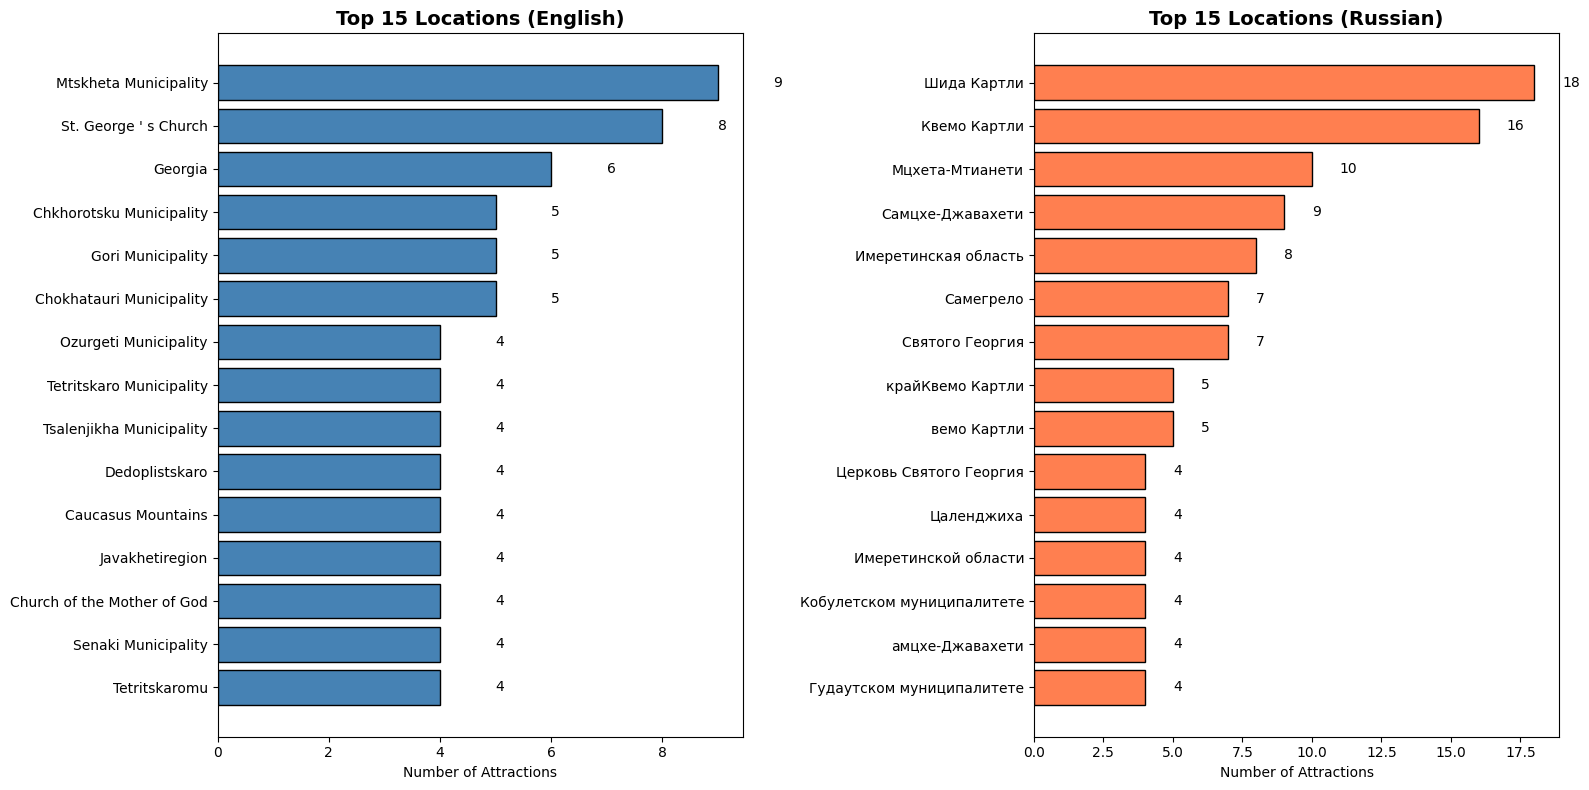

 Visualization complete!


In [32]:
print(" VISUALIZATION")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
# English locations (top 15)
top_loc_en = dict(location_freq_en.most_common(15))
ax1.barh(list(top_loc_en.keys()), list(top_loc_en.values()), color='steelblue', edgecolor='black')
ax1.set_title('Top 15 Locations (English)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Attractions')
ax1.invert_yaxis()

# Add value labels
for i, v in enumerate(top_loc_en.values()):
    ax1.text(v + 1, i, str(v), va='center')
# Russian locations (top 15)
top_loc_ru = dict(location_freq_ru.most_common(15))
ax2.barh(list(top_loc_ru.keys()), list(top_loc_ru.values()), color='coral', edgecolor='black')
ax2.set_title('Top 15 Locations (Russian)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Attractions')
ax2.invert_yaxis()

# Add value labels
for i, v in enumerate(top_loc_ru.values()):
    ax2.text(v + 1, i, str(v), va='center')

plt.tight_layout()
plt.show()
print(" Visualization complete!")


###Summary

In [33]:
print(" LOCATION EXTRACTION SUMMARY")

print(f"English:")
print(f"   Total attractions: {len(df_en)}")
print(f"   With location: {df_en['location_en'].apply(lambda x: len(x) > 0).sum()}")
print(f"   Unique locations: {len(location_freq_en)}")
print(f"   Most common: {location_freq_en.most_common(1)[0][0]} ({location_freq_en.most_common(1)[0][1]} attractions)")

print(f"\nRussian:")
print(f"   Total attractions: {len(df_ru)}")
print(f"   With location: {df_ru['location_ru'].apply(lambda x: len(x) > 0).sum()}")
print(f"   Unique locations: {len(location_freq_ru)}")
print(f"   Most common: {location_freq_ru.most_common(1)[0][0]} ({location_freq_ru.most_common(1)[0][1]} attractions)")

 LOCATION EXTRACTION SUMMARY
English:
   Total attractions: 727
   With location: 712
   Unique locations: 561
   Most common: Mtskheta Municipality (9 attractions)

Russian:
   Total attractions: 901
   With location: 897
   Unique locations: 753
   Most common: Шида Картли (18 attractions)


###Display final results

In [36]:
print(" FINAL ENRICHED DATASETS")

print("\ndf_en (complete):")
print(f"Columns: {list(df_en.columns)}")
display(df_en[['name_en', 'category_en', 'tags_en', 'location_en']].head(5))

print("\ndf_ru (complete):")
print(f"Columns: {list(df_ru.columns)}")
display(df_ru[['name_ru', 'category_ru', 'tags_ru', 'location_ru']].head(5))

print("ENRICHMENT PIPELINE COMPLETE!")

print("""
 All enrichment steps finished!

Final datasets contain:
   ✓ Original data:    name, description
   ✓ NER entities:     ner (locations, organizations, persons)
   ✓ Categories:       category (nature, history, culture, spirituality, architecture)
   ✓ Tags:             tags (searchable keywords)
   ✓ Locations:        location (primary geographical location)

 Dataset statistics:
   • English:  {len_en} attractions fully enriched
   • Russian:  {len_ru} attractions fully enriched
   • Total:    {len_en + len_ru} enriched records

 Ready to save or use for RAG system!
""".format(len_en=len(df_en), len_ru=len(df_ru)))

 FINAL ENRICHED DATASETS

df_en (complete):
Columns: ['name_en', 'description_en', 'ner_en', 'category_en', 'tags_en', 'location_en']


,name_en,category_en,tags_en,location_en
0,Lake Tabatskuri,culture,"[lake, mountain, reserve]",Tabatskuri Reserve
1,Martoti Lake,nature,"[monastery, lake, mountain]",Lagodekhi
2,Sabaduri Forest,nature,"[forest, national park, park]",Tbilisi National Park
3,Lakumurash Toba,nature,"[mountain, lake, reserve]",Mestiamunicipality
4,Small Toba (Okhoje Lake),nature,"[lake, reserve, park]",ChkhorotskuM



df_ru (complete):
Columns: ['name_ru', 'description_ru', 'ner_ru', 'category_ru', 'tags_ru', 'location_ru']


,name_ru,category_ru,tags_ru,location_ru
0,Церковь Святого Георгия в Даба,архитектура,"[собор, церковь, лес]",Церковь Святого Георгия
1,Крепость Коджори (замок Короглы),история,"[замок, крепость, монастырь]",Триалетский Хребет
2,Зеленый монастырь,архитектура,"[монастырь, лес, церковь]",Читахевский Георгиевский монастырь
3,Церковь Потолети,природа,"[церковь, монастырь, собор]",Потолетского лес
4,Тимотесубани Монастырь,архитектура,"[монастырь, церковь, собор]",Тимотесубани монастыр


ENRICHMENT PIPELINE COMPLETE!


KeyError: 'len_en + len_ru'

In [37]:

print(" FINAL ENRICHED DATASETS")


print("\n df_en (complete):")
print(f"Columns: {list(df_en.columns)}")
display(df_en[['name_en', 'category_en', 'tags_en']].head(5))

print("\n df_ru (complete):")
print(f"Columns: {list(df_ru.columns)}")
display(df_ru[['name_ru', 'category_ru', 'tags_ru']].head(5))

# Calculate totals
len_en = len(df_en)
len_ru = len(df_ru)
total = len_en + len_ru

print(f"""

Final datasets contain:
   ✓ Original data:    name, description
   ✓ NER entities:     ner (locations, organizations, persons)
   ✓ Categories:       category (nature, history, culture, spirituality, architecture)
   ✓ Tags:             tags (searchable keywords)

 Dataset statistics:
   • English:  {len_en} attractions fully enriched
   • Russian:  {len_ru} attractions fully enriched
   • Total:    {total} enriched records
""")

 FINAL ENRICHED DATASETS

 df_en (complete):
Columns: ['name_en', 'description_en', 'ner_en', 'category_en', 'tags_en', 'location_en']


,name_en,category_en,tags_en
0,Lake Tabatskuri,culture,"[lake, mountain, reserve]"
1,Martoti Lake,nature,"[monastery, lake, mountain]"
2,Sabaduri Forest,nature,"[forest, national park, park]"
3,Lakumurash Toba,nature,"[mountain, lake, reserve]"
4,Small Toba (Okhoje Lake),nature,"[lake, reserve, park]"



 df_ru (complete):
Columns: ['name_ru', 'description_ru', 'ner_ru', 'category_ru', 'tags_ru', 'location_ru']


,name_ru,category_ru,tags_ru
0,Церковь Святого Георгия в Даба,архитектура,"[собор, церковь, лес]"
1,Крепость Коджори (замок Короглы),история,"[замок, крепость, монастырь]"
2,Зеленый монастырь,архитектура,"[монастырь, лес, церковь]"
3,Церковь Потолети,природа,"[церковь, монастырь, собор]"
4,Тимотесубани Монастырь,архитектура,"[монастырь, церковь, собор]"




Final datasets contain:
   ✓ Original data:    name, description
   ✓ NER entities:     ner (locations, organizations, persons)
   ✓ Categories:       category (nature, history, culture, spirituality, architecture)
   ✓ Tags:             tags (searchable keywords)

 Dataset statistics:
   • English:  727 attractions fully enriched
   • Russian:  901 attractions fully enriched
   • Total:    1628 enriched records



##Summary

In [39]:
def check_completeness(df, lang):
    """Check completeness of enrichment for a dataframe"""

    columns_to_check = {
        'en': ['name_en', 'description_en', 'ner_en', 'category_en', 'tags_en', 'location_en'],
        'ru': ['name_ru', 'description_ru', 'ner_ru', 'category_ru', 'tags_ru', 'location_ru']
    }

    cols = columns_to_check[lang]
    total = len(df)

    print(f"\n{' ENGLISH' if lang == 'en' else ' RUSSIAN'} Dataset:")
    print(f"   Total records: {total}")
    print(f"\n   Field completeness:")

    for col in cols:
        if col in df.columns:
            # Different check for different field types
            if col.endswith('_en') or col.endswith('_ru'):
                if 'ner' in col:
                    # NER is dict
                    filled = df[col].apply(lambda x: len(x) > 0 if isinstance(x, dict) else False).sum()
                elif 'tags' in col:
                    # Tags is list
                    filled = df[col].apply(lambda x: len(x) > 0 if isinstance(x, list) else False).sum()
                else:
                    # String fields
                    filled = df[col].notna().sum()

                percentage = (filled / total) * 100
                bar = "█" * int(percentage / 5)

                print(f"   {col:20s}: {bar:20s} {filled:4d}/{total} ({percentage:.1f}%)")

# Check English
check_completeness(df_en, 'en')

# Check Russian
check_completeness(df_ru, 'ru')

print(" QUALITY METRICS")
def calculate_metrics(df, lang):
    """Calculate quality metrics"""

    prefix = 'en' if lang == 'en' else 'ru'

    # Average entities per attraction
    avg_entities = df[f'ner_{prefix}'].apply(
        lambda x: sum(len(v) for v in x.values()) if isinstance(x, dict) else 0
    ).mean()

    # Average tags per attraction
    avg_tags = df[f'tags_{prefix}'].apply(
        lambda x: len(x) if isinstance(x, list) else 0
    ).mean()

    # Descriptions with minimum length
    min_desc_length = 50
    good_descriptions = df[f'description_{prefix}'].apply(
        lambda x: len(str(x)) >= min_desc_length
    ).sum()

    # Category distribution entropy (diversity)
    from scipy.stats import entropy
    category_dist = df[f'category_{prefix}'].value_counts(normalize=True)
    category_entropy = entropy(category_dist)

    return {
        'avg_entities': avg_entities,
        'avg_tags': avg_tags,
        'good_descriptions': good_descriptions,
        'category_entropy': category_entropy
    }

metrics_en = calculate_metrics(df_en, 'en')
metrics_ru = calculate_metrics(df_ru, 'ru')

print("\n English Metrics:")
print(f"   Average NER entities per attraction: {metrics_en['avg_entities']:.1f}")
print(f"   Average tags per attraction: {metrics_en['avg_tags']:.1f}")
print(f"   Descriptions ≥50 chars: {metrics_en['good_descriptions']}/{len(df_en)} ({metrics_en['good_descriptions']/len(df_en)*100:.1f}%)")
print(f"   Category diversity (entropy): {metrics_en['category_entropy']:.2f}")

print("\n Russian Metrics:")
print(f"   Average NER entities per attraction: {metrics_ru['avg_entities']:.1f}")
print(f"   Average tags per attraction: {metrics_ru['avg_tags']:.1f}")
print(f"   Descriptions ≥50 chars: {metrics_ru['good_descriptions']}/{len(df_ru)} ({metrics_ru['good_descriptions']/len(df_ru)*100:.1f}%)")
print(f"   Category diversity (entropy): {metrics_ru['category_entropy']:.2f}")

print(" SAMPLE ENRICHED ATTRACTIONS")
def display_enriched_sample(df, idx, lang):
    """Display a beautifully formatted enriched attraction"""

    prefix = 'en' if lang == 'en' else 'ru'
    row = df.iloc[idx]

    print(f"\n{'─' * 70}")
    print(f" {row[f'name_{prefix}']}")
    print(f"{'─' * 70}")
    print(f" Description:")
    print(f"   {row[f'description_{prefix}'][:200]}...")
    print(f"\n  Category: {row[f'category_{prefix}']}")
    print(f" Tags: {', '.join(row[f'tags_{prefix}'][:5])}")
    print(f" Location: {row[f'location_{prefix}']}")

    if isinstance(row[f'ner_{prefix}'], dict):
        print(f"\n Named Entities:")
        for entity_type, entities in row[f'ner_{prefix}'].items():
            if entities:
                print(f"   {entity_type}: {', '.join(entities[:3])}")

print("\n English Samples:")
for i in range(min(2, len(df_en))):
    display_enriched_sample(df_en, i, 'en')

print("\n Russian Samples:")
for i in range(min(2, len(df_ru))):
    display_enriched_sample(df_ru, i, 'ru')


 ENGLISH Dataset:
   Total records: 727

   Field completeness:
   name_en             : ████████████████████  727/727 (100.0%)
   description_en      : ████████████████████  727/727 (100.0%)
   ner_en              : ███████████████████   721/727 (99.2%)
   category_en         : ████████████████████  727/727 (100.0%)
   tags_en             : ████████████████████  727/727 (100.0%)
   location_en         : ████████████████████  727/727 (100.0%)

 RUSSIAN Dataset:
   Total records: 901

   Field completeness:
   name_ru             : ████████████████████  901/901 (100.0%)
   description_ru      : ████████████████████  901/901 (100.0%)
   ner_ru              : ███████████████████   898/901 (99.7%)
   category_ru         : ████████████████████  901/901 (100.0%)
   tags_ru             : ████████████████████  901/901 (100.0%)
   location_ru         : ████████████████████  901/901 (100.0%)
 QUALITY METRICS

 English Metrics:
   Average NER entities per attraction: 15.7
   Average tags per att

In [40]:
print(" ENRICHMENT PIPELINE COMPLETED!")
print("""
This notebook demonstrated a complete NLP enrichment pipeline for the
Georgian Attractions dataset, transforming raw descriptions into
structured, searchable data.
""")
accomplishments = [
    (" Data Loading", f"Loaded and prepared {len(df_en)} English + {len(df_ru)} Russian attractions"),
    ("  Named Entity Recognition", f"Extracted {df_en['ner_en'].apply(lambda x: sum(len(v) for v in x.values()) if isinstance(x, dict) else 0).sum() + df_ru['ner_ru'].apply(lambda x: sum(len(v) for v in x.values()) if isinstance(x, dict) else 0).sum()} total entities"),
    (" Category Classification", f"Classified into 5 semantic categories"),
    (" Tag Generation", f"Generated {df_en['tags_en'].apply(lambda x: len(x) if isinstance(x, list) else 0).sum() + df_ru['tags_ru'].apply(lambda x: len(x) if isinstance(x, list) else 0).sum()} searchable tags"),
    (" Location Extraction", f"Extracted {(df_en['location_en'] != '').sum() + (df_ru['location_ru'] != '').sum()} geographical locations")
]

for step, result in accomplishments:
    print(f"\n{step}")
    print(f"   → {result}")

# Create summary table
summary_data = {
    'Metric': [
        'Total Attractions',
        'Fully Enriched',
        'Total NER Entities',
        'Total Tags',
        'Locations Found',
        'Categories Used',
        'Avg Entities/Attraction',
        'Avg Tags/Attraction'
    ],
    'English': [
        len(df_en),
        len(df_en),
        df_en['ner_en'].apply(lambda x: sum(len(v) for v in x.values()) if isinstance(x, dict) else 0).sum(),
        df_en['tags_en'].apply(lambda x: len(x) if isinstance(x, list) else 0).sum(),
        (df_en['location_en'] != '').sum(),
        df_en['category_en'].nunique(),
        f"{df_en['ner_en'].apply(lambda x: sum(len(v) for v in x.values()) if isinstance(x, dict) else 0).mean():.1f}",
        f"{df_en['tags_en'].apply(lambda x: len(x) if isinstance(x, list) else 0).mean():.1f}"
    ],
    'Russian': [
        len(df_ru),
        len(df_ru),
        df_ru['ner_ru'].apply(lambda x: sum(len(v) for v in x.values()) if isinstance(x, dict) else 0).sum(),
        df_ru['tags_ru'].apply(lambda x: len(x) if isinstance(x, list) else 0).sum(),
        (df_ru['location_ru'] != '').sum(),
        df_ru['category_ru'].nunique(),
        f"{df_ru['ner_ru'].apply(lambda x: sum(len(v) for v in x.values()) if isinstance(x, dict) else 0).mean():.1f}",
        f"{df_ru['tags_ru'].apply(lambda x: len(x) if isinstance(x, list) else 0).mean():.1f}"
    ]
}

summary_df = pd.DataFrame(summary_data)
display(summary_df)

print("\n BEFORE Enrichment:")
print("""
   ┌─────────────────────────────────────┐
   │ name                                │
   │ description                         │
   └─────────────────────────────────────┘

   Limited searchability and structure.
""")

print(" AFTER Enrichment:")
print("""
   ┌─────────────────────────────────────┐
   │ name                                │
   │ description                         │
   │ ner          ← Entities extracted   │
   │ category     ← Semantic class       │
   │ tags         ← Searchable keywords  │
   │ location     ← Geographic info      │
   └─────────────────────────────────────┘

   Rich metadata for search, filtering, and RAG!
""")


models_info = {
    'Task': ['NER (English)', 'NER (Russian)', 'Classification', 'Tags'],
    'Model': [
        'dslim/bert-base-NER',
        'Davlan/xlm-roberta-base-ner-hrl',
        'joeddav/xlm-roberta-large-xnli',
        'joeddav/xlm-roberta-large-xnli'
    ],
    'Size': ['~500MB', '~700MB', '~2GB', '~2GB (reused)']
}

models_df = pd.DataFrame(models_info)
display(models_df)

print("""
 Original Dataset:
   https://huggingface.co/datasets/AIAnastasia/Georgian-attractions
 The next step is to prepare and publish the dataset, which is located in the repository: unification-georgian-attractions-datasets.
 Also, the creation of a Qdrant database for this dataset is located in the repository: georgian-attractions-qdrant
""")

print("💝 THANK YOU!")

print("""
Thank you for completing this enrichment pipeline notebook!

This educational demonstration showed how modern NLP techniques can
transform raw text into structured, searchable knowledge.

 If you found this helpful:
   •  Star the repository
   •  Share with others
   •  Provide feedback
   •  Build something amazing!

Happy coding!Made with love for NLP community.
""")

print("\n English Dataset Preview:")
display(df_en.head(3))

print("\n Russian Dataset Preview:")
display(df_ru.head(3))


 ENRICHMENT PIPELINE COMPLETED!

This notebook demonstrated a complete NLP enrichment pipeline for the
Georgian Attractions dataset, transforming raw descriptions into
structured, searchable data.


 Data Loading
   → Loaded and prepared 727 English + 901 Russian attractions

  Named Entity Recognition
   → Extracted 21778 total entities

 Category Classification
   → Classified into 5 semantic categories

 Tag Generation
   → Generated 4884 searchable tags

 Location Extraction
   → Extracted 1609 geographical locations


,Metric,English,Russian
0,Total Attractions,727,901
1,Fully Enriched,727,901
2,Total NER Entities,11412,10366
3,Total Tags,2181,2703
4,Locations Found,712,897
5,Categories Used,5,5
6,Avg Entities/Attraction,15.7,11.5
7,Avg Tags/Attraction,3.0,3.0



 BEFORE Enrichment:

   ┌─────────────────────────────────────┐
   │ name                                │
   │ description                         │
   └─────────────────────────────────────┘

   Limited searchability and structure.

 AFTER Enrichment:

   ┌─────────────────────────────────────┐
   │ name                                │
   │ description                         │
   │ ner          ← Entities extracted   │
   │ category     ← Semantic class       │
   │ tags         ← Searchable keywords  │
   │ location     ← Geographic info      │
   └─────────────────────────────────────┘

   Rich metadata for search, filtering, and RAG!



,Task,Model,Size
0,NER (English),dslim/bert-base-NER,~500MB
1,NER (Russian),Davlan/xlm-roberta-base-ner-hrl,~700MB
2,Classification,joeddav/xlm-roberta-large-xnli,~2GB
3,Tags,joeddav/xlm-roberta-large-xnli,~2GB (reused)



 Original Dataset:
   https://huggingface.co/datasets/AIAnastasia/Georgian-attractions
 The next step is to prepare and publish the dataset, which is located in the repository: unification-georgian-attractions-datasets.
 Also, the creation of a Qdrant database for this dataset is located in the repository: georgian-attractions-qdrant

💝 THANK YOU!

Thank you for completing this enrichment pipeline notebook!

This educational demonstration showed how modern NLP techniques can
transform raw text into structured, searchable knowledge.

 If you found this helpful:
   •  Star the repository
   •  Share with others
   •  Provide feedback
   •  Build something amazing!

Happy coding!Made with love for NLP community.


 English Dataset Preview:


,name_en,description_en,ner_en,category_en,tags_en,location_en
0,Lake Tabatskuri,Lake Tabatskuriis located inSamtskhe - Javakhe...,"{'LOC': ['Lake', 'Tabatskuri', '##Samtskhe', '...",culture,"[lake, mountain, reserve]",Tabatskuri Reserve
1,Martoti Lake,LakeMartotiis located inKakhetiregion specific...,"{'LOC': ['Lake', '##artot', '##Kakhetire', '##...",nature,"[monastery, lake, mountain]",Lagodekhi
2,Sabaduri Forest,Sabaduri Forestis located in theMtskheta-Mtian...,"{'LOC': ['Sabaduri Forest', '##heta', 'Mtianet...",nature,"[forest, national park, park]",Tbilisi National Park



 Russian Dataset Preview:


,name_ru,description_ru,ner_ru,category_ru,tags_ru,location_ru
0,Церковь Святого Георгия в Даба,Церковь Святого Георгия в Даба находится в мун...,"{'LOC': ['Церковь Святого Георгия', 'Даба', 'Б...",архитектура,"[собор, церковь, лес]",Церковь Святого Георгия
1,Крепость Коджори (замок Короглы),Крепость Коджори(замок Короглы)- находится вТб...,"{'LOC': ['Крепость Коджори', 'замок', 'Короглы...",история,"[замок, крепость, монастырь]",Триалетский Хребет
2,Зеленый монастырь,Зеленый монастырь(Читахевский Георгиевский мон...,"{'LOC': ['Зеленый монастырь', 'Читахевский Гео...",архитектура,"[монастырь, лес, церковь]",Читахевский Георгиевский монастырь
